# Map of regions

for article

## Setup

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.ticker import LogLocator
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import palettable.cmocean.sequential as cmOcSeq
import palettable.cmocean.diverging as cmOcDiv
import seaborn as sns

import textwrap as tw
from datetime import datetime, timedelta

from glob import glob 


import utilsRegions as urgn
import utilsGen as utl
import mapPlots as mplt
import diagnostics as dgnst
import utlshistograms as uhist

%load_ext autoreload
%autoreload 2

#### Load data 

In [2]:
scenarios = ['historical-DFS-G510.00','RCP85-G510.14-G515.00-01']
hist,rcp85 = scenarios
periods = ['1981-2000','2023-2042','2066-2085']
past,pres,futur=periods
runs={past:hist, pres:rcp85, futur:rcp85}
timeperiod = {past: slice('1981','2000'), pres:slice('2023','2042'), futur: slice('2066','2085') }

dadic={}
utl.loadNAAmesh(dadic)

In [3]:
# for scn in scenarios: 
#     utl.openNCfile(dadic,scn,'biolog')
#     utl.openNCfile(dadic,scn,'diad')

#### Regions

In [3]:
dmaskNAA = xr.open_dataset('/tsanta/ahaddon/NAA/mesh/RegionalMasksNAA.nc')
dmesh = xr.open_dataset('/tsanta/ahaddon/NAA/mesh/mesh_mask_naa1_rn_hmin7.nc')
landMask = dmesh.tmask.isel(t=0, z= 0)

In [4]:
regions, rgnMsk, rgnArea = urgn.loadRegions()
cList = plt.colormaps['tab20b'](np.arange(14)/13)
clrs={r:c for r,c in zip(regions,cList)}

extent={}
CAA = 'Canadian Arctic Archipelago'
extent[CAA]=[-124,-77, 67,85]
# SES ='S. East Siberian Sea'
# extent[SES]=[88,165, 68,90]
# CHU = 'S. Chuckchi Sea'
# extent[CHU]=[150,210,60,90]

BEAU = 'Beaufort Sea'
regions.append(BEAU)
rgnMsk[BEAU]= ( rgnMsk['N. Beaufort Sea'] | rgnMsk['S. Beaufort Sea'] )
rgnArea[BEAU] = dadic['didj'].where(rgnMsk[BEAU]).sum(dim=['y','x']).compute()
extent[BEAU] = [-120,-175,65,85]

LAP='Laptev Sea'
regions.append(LAP)
rgnMsk[LAP]= rgnMsk['S. East Siberian Sea'] & (dadic['mesh'].nav_lon>105) & (dadic['mesh'].nav_lon<140)
rgnArea[LAP] = dadic['didj'].where(rgnMsk[LAP]).sum(dim=['y','x']).compute()
extent[LAP]=[80,180, 70,90] 
def pltBdnryLaptev(fig,ax):
    ax.plot([140]*2,[71.5,79],'k-', transform=ccrs.PlateCarree(), lw=1.5)
    ax.plot([105]*2,[77.6,79.7], 'k-',transform=ccrs.PlateCarree(), lw=1.5)
    mplt.pltRgnBdnry(fig,ax,rgnMsk['S. East Siberian Sea']*(dadic['mesh'].nav_lon>105) *(dadic['mesh'].nav_lon<140), dmaskNAA, landMask, s=0.3,color='k',marker='o')    

SIB='E. Siberia Sea'
regions.append(SIB)
rgnMsk[SIB]= ( (rgnMsk['S. East Siberian Sea'] & (dadic['mesh'].nav_lon>140) )
              | (rgnMsk['S. Chuckchi Sea'] & (dadic['mesh'].nav_lon<180) & (dadic['mesh'].nav_lon>140) )
             )
rgnArea[SIB] = dadic['didj'].where(rgnMsk[SIB]).sum(dim=['y','x']).compute()
extent[SIB]=[130,190, 65,88]
def pltBdnrySiberia(fig,ax,wb=False):
    mplt.pltRgnBdnry(fig,ax,rgnMsk['S. East Siberian Sea']*(dadic['mesh'].nav_lon>140) *(dadic['mesh'].nav_lon<161.4), dmaskNAA, landMask, s=0.3,color='k')
    mplt.pltRgnBdnry(fig,ax,rgnMsk['S. Chuckchi Sea']*(dadic['mesh'].nav_lon>162.6), dmaskNAA, landMask,s=0.3,color='k')
    ax.scatter([161.9,162.5], [79,78.9],  transform=ccrs.PlateCarree(),s=0.3,color='k')
    ax.plot([180]*2,[69,75.2],'k-', transform=ccrs.PlateCarree(), lw=1.5)
    if wb: ax.plot([140]*2,[71.5,79],'k-', transform=ccrs.PlateCarree(), lw=1.5)
extent[SIB+LAP]=[80,190,65,90]    

regs = [CAA,BEAU,SIB,LAP]

(None, None)

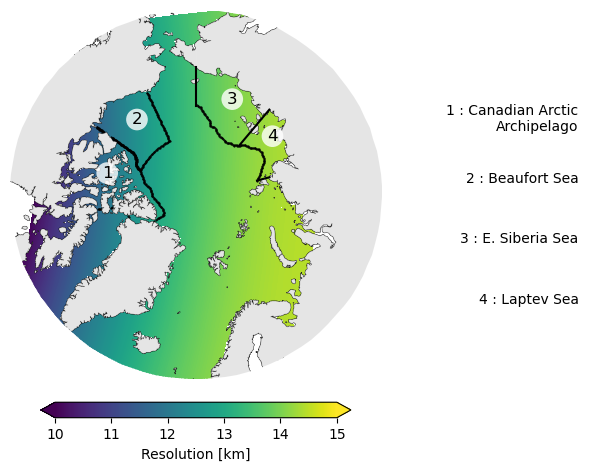

In [10]:
# plt.rcParams.update({'font.size': 14})

nregions=len(regs)
gs = gridspec.GridSpec(3, 2, width_ratios=[3, 0], height_ratios=[0.5-(nregions/14),2*(nregions/14),0.6-(nregions/14) ],wspace=.0) 
fig=plt.figure(figsize=(10,6))

ax0=plt.subplot(gs[0:3,0],projection=ccrs.NorthPolarStereo(),frameon=False)
ax0.coastlines(linewidth=0.5,resolution='50m')
ax0.set_extent([-180,180, 60,90] , ccrs.PlateCarree())
mplt.roundBoundary(ax0)
ax0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor=cfeature.COLORS['land_alt1'],alpha=0.7) )

mplt.singleMap((dadic['didj']/1e6)**(1/2),dadic,fig=fig,ax=ax0,vmin=10,vmax=15,unitName='Resolution [km]')

# regions boundaries + number
dmaskNAA['region']=xr.where(dmaskNAA.region==6, 5,dmaskNAA.region) # elimiate boundary between N and S beaufort
for ir,rgn in enumerate(regs[:2]):
    mplt.pltRgnBdnry(fig,ax0,rgnMsk[rgn], dmaskNAA, landMask, s=0.3,color='k',marker='o')
pltBdnryLaptev(fig,ax0)
pltBdnrySiberia(fig,ax0)

# regions number
for ir,rgn in enumerate(regs):
    lon,lat = dmaskNAA.nav_lon.where(rgnMsk[rgn]).load().median(),dmaskNAA.nav_lat.where(rgnMsk[rgn]).load().median()
    ax0.text(lon,lat,str(ir+1), transform=ccrs.PlateCarree(),fontsize=12,
                  bbox={'fc':'w','lw':0,'alpha':0.8, 'pad': 0.2,'boxstyle':'circle'})

ax1=plt.subplot(gs[1,1])
ax1.spines[["left", "top", "right",'bottom']].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks(range(2*nregions), [f'{int(i/2)+1} : {tw.fill(regs[int(i/2)],16)}' if i%2==0 else '' for i in range(2*nregions)])#, wrap=True)
ax1.invert_yaxis(), ax1.tick_params(axis='y', length=0) 


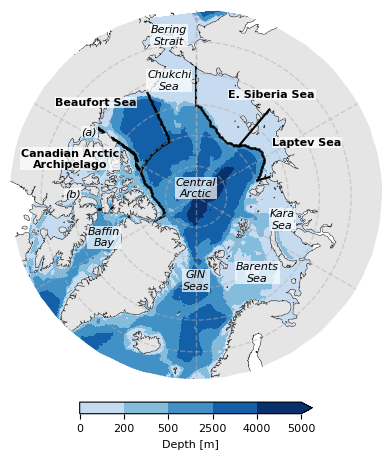

In [6]:
plt.rcParams.update({'font.size': 8})

fig,ax=plt.subplots(figsize=(10,6),subplot_kw={'projection':ccrs.NorthPolarStereo()} )    

ax.coastlines(linewidth=0.5,resolution='50m')
ax.set_extent([-180,180, 60,90] , ccrs.PlateCarree())
mplt.roundBoundary(ax)
ax.axis('off')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor=cfeature.COLORS['land_alt1'],alpha=0.7) )
gl=ax.gridlines(lw=1,alpha=0.5,ls='--', draw_labels=False)
# gl.ylocator = mticker.FixedLocator([60,70,80])

mplt.singleMap(dadic['mesh'].hdept.squeeze(),dadic,fig=fig,ax=ax,
            #    vmin=0,vmax=15, extend=None,
               cmap=colors.ListedColormap( plt.get_cmap('Blues')(np.linspace(0.25,1,5)) ) ,
               norm = colors.BoundaryNorm([0,200,500,2500,4000,5000], ncolors=5),extend='max',
               unitName='Depth [m]', shrinkcbar=0.3)
# mplt.singleMap((dadic['didj']/1e6)**(1/2),dadic,fig=fig,ax=ax,
#                vmin=10,vmax=15, extend=None,
#                unitName='Resolution [km]', shrinkcbar=0.3)

# regions boundaries 
dmaskNAA['region']=xr.where(dmaskNAA.region==6, 5,dmaskNAA.region) # elimiate boundary between N and S beaufort
for ir,rgn in enumerate(regs[:2]):
    mplt.pltRgnBdnry(fig,ax,rgnMsk[rgn], dmaskNAA, landMask, s=0.3,color='k',marker='o')
pltBdnryLaptev(fig,ax)
pltBdnrySiberia(fig,ax)


ax.text(-103,69,'Canadian Arctic\nArchipelago',transform=ccrs.PlateCarree(),fontsize=8, weight='bold', ha='center',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})
ax.text(-123,63,BEAU,transform=ccrs.PlateCarree(),fontsize=8,weight='bold',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})
ax.text(162,73,SIB,transform=ccrs.PlateCarree(),fontsize=8,weight='bold',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})
ax.text(124,75,LAP,transform=ccrs.PlateCarree(),fontsize=8,weight='bold',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})

ax.text(-166,72,'Chukchi\nSea',transform=ccrs.PlateCarree(),fontsize=8,  style='italic',ha='center',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})
ax.text(-170,65,'Bering\nStrait',transform=ccrs.PlateCarree(),fontsize=8,  style='italic',ha='center',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})
ax.text(-62,73,'Baffin\nBay',transform=ccrs.PlateCarree(),fontsize=8,  style='italic',ha='center',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})
ax.text(36,73,'Barents\nSea',transform=ccrs.PlateCarree(),fontsize=8,  style='italic',ha='center',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})
ax.text(70,75,'Kara\nSea',transform=ccrs.PlateCarree(),fontsize=8,  style='italic',ha='center',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})
ax.text(0,90,'Central\nArctic',transform=ccrs.PlateCarree(),fontsize=8,  style='italic',ha='center',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})
ax.text(0,75,'GIN\nSeas',transform=ccrs.PlateCarree(),fontsize=8,  style='italic',ha='center',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})

ax.text(-120,70,'(a)',transform=ccrs.PlateCarree(),fontsize=8,  style='italic',ha='center',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})
ax.text(-90,70,'(b)',transform=ccrs.PlateCarree(),fontsize=8,  style='italic',ha='center',
         bbox={'fc':'w','lw':0,'alpha':0.7, 'pad': 0.5})



plt.savefig('../figs/IAphenology23/arctic-map-90dpi.png',bbox_inches='tight',dpi=90)
plt.savefig('../figs/IAphenology23/arctic-map-300dpi.png',bbox_inches='tight',dpi=300)

In [116]:
plt.get_cmap('Blues')(np.linspace(0.1,1,5))

array([[0.89173395, 0.93510188, 0.97539408, 1.        ],
       [0.68173779, 0.81856209, 0.90409842, 1.        ],
       [0.35655517, 0.63929258, 0.81460977, 1.        ],
       [0.10865052, 0.41656286, 0.68904268, 1.        ],
       [0.03137255, 0.18823529, 0.41960784, 1.        ]])